# Setting

In [1]:
# import libraries
import mne, os, pickle, glob
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
# directories
mri_dir  = os.path.realpath('../Data/mri')     # mri directory
meg_dir  = os.path.realpath('../Data/meg-exp') # meg directory
log_dir  = os.path.join(meg_dir, 'log')        # log directory
stc_dir  = os.path.join(meg_dir, 'stc')        # stc directory
mod_dir  = os.path.join(meg_dir, 'mod')        # GLM model directory
res_dir  = os.path.join(meg_dir, 'res')        # results directory

# subject list
subjects = ['P049']

# GLM
- model: intercep + 7 conditions + LogBaseFrequency + WordLength + accuracy + trial order
- conditons: ArgStrViolNAG, ArgStrViolNA, CatViolNAG, CatViolNA, GrammNAG, GrammNA, Fillers

## define parameters

In [3]:
# define event codes
event_id  = dict(ArgStrViolNAG = 10, ArgStrViolNA = 20, 
                 CatViolNAG    = 30, CatViolNA    = 40, 
                 GrammNAG      = 50, GrammNA      = 60, 
                 Filler        = 70)
cond_code = list(event_id.values())  # condition code
cond_name = list(event_id.keys())    # condition name

# define regressors (12 regressors)
# constant + 7 conditions + LogBaseFrequency + WordLength + accuracy + trial order
col_labels = cond_name.copy()
col_labels.insert(0, 'constant')
for item in ['LogBaseFreq', 'Length', 'RespACC', 'trial order']: col_labels.append(item)

# define variables
epoch_tmin = -0.1  # epoch onset
epoch_tmax = 0.6   # epoch offset
times      = np.arange(epoch_tmin*1000, epoch_tmax*1000+1, 1)
n_cond     = len(cond_code)   # number of conditions
n_reg      = len(col_labels)  # number of regressors
n_times    = len(times)       # number of time points
n_sources  = 5124             # number of sources

## prep for model

In [4]:
subj = subjects[0]
print(subj)
print('read log...')

# read stimuli parameters
stim_fname = os.path.join(log_dir, 'stim_param.csv')
df_stim    = pd.read_csv(stim_fname, sep=',')

# read log file
log_fname = os.path.join(log_dir, '%s_SAVANTTAG_log.csv') %(subj)
log_df    = pd.read_csv(log_fname, sep=',')
n_total   = log_df.shape[0]                              # number of total trials

# keep good trials (exlude trials with artifact)
keep_list = log_df['accept'] == 1                        # look for good trials (accept==1)
log_keep  = log_df[keep_list]
n_trl     = log_keep.shape[0]                            # number of good trials

# retrieve stimuli parameters for good trials
item_idx  = pd.Index(log_keep.itemcode)                  # item codes of good trials
stim_keep = df_stim[df_stim['itemcode'].isin(item_idx)]  # subset of stimuli parameters of good trials
stim_keep = stim_keep.set_index('itemcode').loc[item_idx].reset_index()
log_subj  = pd.merge(log_keep, stim_keep)                # combine behavioral log and stimuli parameters

# create function to center data
center_function = lambda x: x - x.mean()
# centering stimuli parameters
LogBaseFreq_centered = center_function(np.log(log_subj['BaseFreq'].values))
Len_centered         = center_function(log_subj['Length'].values)

# prep for design matrix and stc data
trl_list   = log_subj['trial'].values              # trial number
cond_list  = log_subj['cond'].values               # condition
resp_list  = (log_subj['resp'].values == 'hit')*1  # trial accuracy 
design_mtx = np.zeros((n_trl, n_reg-1))            # create an empty design matrix
data_mtx   = np.empty((n_sources, n_times, n_trl)) # source x time x trial

# recode conditions
recode_list = [71, 80, 81, 90, 91]
for rc_count, rc in enumerate(recode_list):
    recode_idx = np.where(cond_list == rc)[0]
    cond_list[recode_idx] = 70

P049
read log...


## load single-trial stc data & model building

In [5]:
# subject folder
subj_dir = os.path.join(stc_dir, '%s') %(subj)
os.chdir(subj_dir)

# load stc
print('load stc...')
for i, trl in enumerate(trl_list):

    # assign values to design matrix
    cond_num = cond_list[i]
    cond_col = cond_code.index(cond_num)
    design_mtx[i, cond_col] = 1
    design_mtx[i, n_cond]   = LogBaseFreq_centered[i]
    design_mtx[i, n_cond+1] = Len_centered[i]
    design_mtx[i, n_cond+2] = resp_list[i]
    design_mtx[i, -1] = trl/n_total

    # stc data
    glob_name = '%s_trl-%s_*.stc' %(subj, str(trl).rjust(3,'0'))
    stc_fname = sorted(glob.glob(glob_name))[0]
    stc = mne.read_source_estimate(stc_fname)
    data_mtx[:,:,i] = stc.data.copy()
    
# add constant to the design matrix
# 12 regressors: intercept + 7 conditions + LogBaseFrequency + WordLength + accuracy + trial order
X = sm.add_constant(design_mtx)

load stc...


## visualizing design matrix

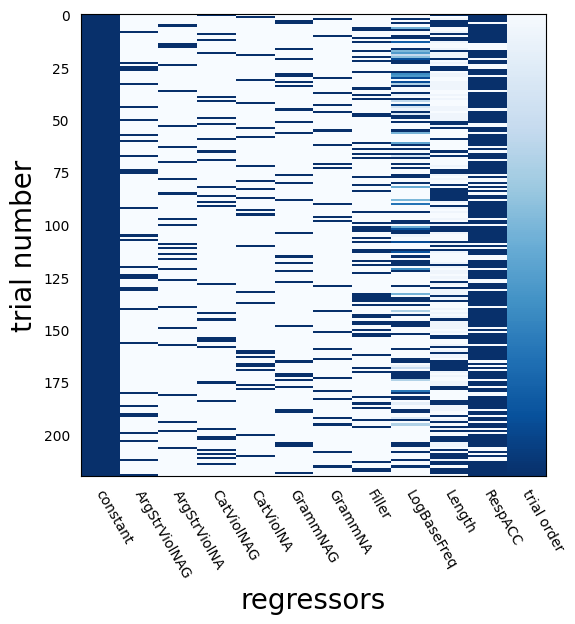

In [6]:
plt.figure(figsize=(6,6))
plt.imshow(X, cmap='Blues', vmin=0, vmax=1, interpolation='nearest', aspect='auto')
plt.xlabel('regressors', fontsize=20)
plt.ylabel('trial number', fontsize=20)
plt.xticks(ticks=np.arange(0,n_reg)-0.2, labels=col_labels, rotation=-60, ha='left')
plt.tick_params(axis='both', length=0, pad=8, labelsize=10)
plt.show()

## model fitting

In [7]:
# create an empty matrix for storing beta coefficients from GLM
b_map = np.empty((n_sources, n_times, n_reg))
    
# model fitting
print('model fitting...')
for v in range(n_sources):

    if v%100 == 0:
        print(v, end=' ')
    
    # fitting GLM model to the data values at each time point for each vertex
    for t in range(n_times):
        y   = data_mtx[v,t,:]      # dimensions: source x time x item
        est = sm.OLS(y, X).fit()
        b_map[v,t,:] = est.params  # dimensions: source x time x regressor

# save beta map
b_fname = os.path.join(mod_dir, '%s_reg%s_b-map.npy') %(subj, n_reg)
np.save(b_fname, b_map)

model fitting...
0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 